In [3]:
from torch.utils.data import Dataset, DataLoader
from glob import glob
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [4]:
class ASRPerfMonitorDataset(Dataset):
    def __init__(self, data_dir):
        self.npy_files = glob(f'{data_dir}/*.npy')

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        contents = np.load(self.npy_files[idx], allow_pickle = True)
        x = torch.from_numpy(contents.item().get('logits_history'))
        y = torch.tensor(contents.item().get('cer')[0])
        sample = {'logits': x, 'cer': y}
        return sample

In [5]:
def symmetric_kl_div(a, b):
    a = F.softmax(a, dim=0)
    b = F.softmax(b, dim=0)
    return F.kl_div(a, b) + F.kl_div(b, a)

In [18]:
def get_scores_and_labels(dataset):
    x = []
    y = []
    windows = [1,2,3,4,5]
    for idx in range(len(dataset.npy_files)):
        data = dataset[idx]
        logits = data['logits']
        cer = data['cer'].numpy().tolist()
        if cer != 0:
            mcd = 0
            norm = 1
            for ws in windows:
                a1 = 0
                for i in range(ws, len(logits)):
                    a1 += symmetric_kl_div(logits[i-ws], logits[i])
                mcd += a1
                norm += (len(logits) - ws)
            m_score = mcd / norm
            x.append(m_score)
            y.append(cer)
    x = np.array(x)
    x = np.expand_dims(x, axis=1)
    y = np.array(y)
    return x, y

In [19]:
dev_set = ASRPerfMonitorDataset('/home/neo/Desktop/projects/perf_monitor/dev/')
test_set = ASRPerfMonitorDataset('/home/neo/Desktop/projects/perf_monitor/test/')

In [20]:
x_dev, y_dev = get_scores_and_labels(dev_set)

In [21]:
x_test, y_test = get_scores_and_labels(test_set)

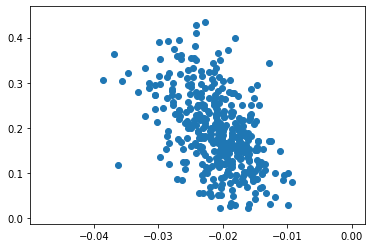

In [22]:
plt.scatter(x_dev, y_dev)

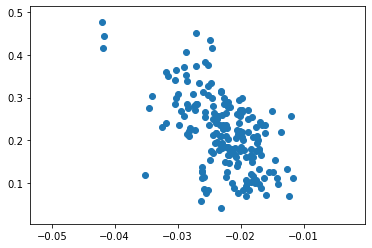

In [23]:
plt.scatter(x_test, y_test)

In [24]:
reg = LinearRegression().fit(x_dev, y_dev)

In [25]:
reg.score(x_dev,y_dev)

0.23410089656774724

In [27]:
yy_dev = reg.predict(x_dev)

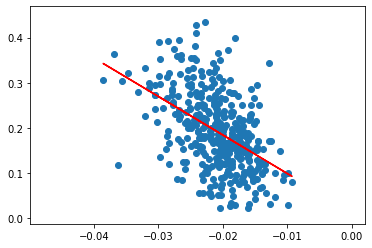

In [29]:
plt.scatter(x_dev, y_dev)
plt.plot(x_dev, yy_dev, color='red')

In [30]:
yy_test = reg.predict(x_test)

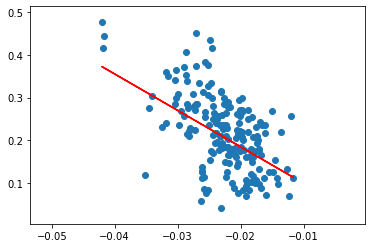

In [31]:
plt.scatter(x_test, y_test)
plt.plot(x_test, yy_test, color='red')